---

# EmilioBot 2.0

## LLM model based on Emilio's whatsapp messages, built and trained from scratch by Ege

---

In [82]:
# Imports
import tiktoken as tkn
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
torch.cuda.is_available()

True

In [3]:
DATA_TXT = "EMILIO_CLEANED.txt"

In [4]:
with open(DATA_TXT, "r", encoding="utf-8") as f:
	text = f.read()

In [5]:
print(f"Length of the dataset in characters: {len(text)}")

Length of the dataset in characters: 351478


In [6]:
print(text[100:250])

let
Let’s hang out
Yeah I’m in Ikea
Had to buy some shit for home
N
K*
I’m still in IKEA lol
Yeah
Yeah
I’m outside
Right at the entrance
I’d be down t


In [7]:
characters = sorted(list(set(text)))
vocab_size = len(characters)
print(f"Number of unique characters: {vocab_size}")
print("".join(characters))

Number of unique characters: 233

 !"#$%&'()*+,-./0123456789:;=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ^abcdefghijklmnopqrstuvwxyz{} «´»ÀÁÖàáãçèéêëíïñóôöüЧаделоть‍‎‘’“”…‼⁉€☕☠♂❎一三不中二作十号喜四国大天学工律我时月欢法的紫老进难鹃️🌳🍀🍷🏫🐊🐐🐱👊👍👎👑👨💀💃💅💤💪💯📠📸🔥🗣😂😈😍😎😐😔😕😞😤😨😩😫😭😱😲😳😴😼🙁🚩🚬🤌🤑🤓🤔🤙🤝🤞🤠🤡🤢🤣🤤🤨🤩🤪🤮🤯🤷🥖🥴🥵🥶🥸🥹🥺🦅🧉🧐🧢🫡


In [8]:
stoi = {c: i for i, c in enumerate(characters)}
itos = {i: c for i, c in enumerate(characters)}

encode = lambda x: [stoi[c] for c in x]
decode = lambda x: "".join([itos[i] for i in x])

print(encode("Yo man, what's up?"))
print(decode(encode("Yo man, what's up?")))

[57, 74, 1, 72, 60, 73, 13, 1, 82, 67, 60, 79, 8, 78, 1, 80, 75, 31]
Yo man, what's up?


In [9]:
data = torch.tensor(encode(text), dtype=torch.long)

In [10]:
print(data.shape, data.dtype)

torch.Size([351478]) torch.int64


In [11]:
print(data[:100])

tensor([18,  1, 68, 72, 75, 60, 78, 78, 64,  1, 37, 80, 66, 99, 73, 64,  1, 36,
        64, 71, 60, 62, 77, 74, 68, 83,  1, 26, 21, 17, 17, 17,  0, 36, 60, 72,
        73,  1, 79, 67, 64, 77, 64,  1, 60, 77, 64,  1, 78, 74, 72, 64,  1, 42,
        64, 82, 78,  1, 68, 73,  1, 72, 84,  1, 33, 75, 75, 60, 77, 79, 64, 72,
        64, 73, 79,  1, 62, 74, 72, 75, 71, 64, 83,  0, 57, 74,  0, 35, 74, 72,
        64,  1, 79, 74,  1, 62, 67, 60, 79, 64])


In [12]:
train_percentage = 90/100
n = int(train_percentage*len(data))

train_data = data[:n]
test_data = data[n:]

In [13]:
train_data[:8]

tensor([18,  1, 68, 72, 75, 60, 78, 78])

In [14]:
batch_size = 4
block_size = 8

def get_batch(split, batch_size=4, block_size=8,  train=train_data, test=test_data):
    data = train if split == "train" else test
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y


In [15]:
torch_seed = 28042003
torch.manual_seed(torch_seed)

xb, yb = get_batch("train", 4, 8, train_data, test_data)

In [16]:
print("----------------------------------------------\n")
print(f"Inputs:\n\n\t{xb.shape}\n\n{xb}")
print("\n----------------------------------------------\n")
print(f"Targets:\n\n\t{yb.shape}\n\n{yb}")
print("\n----------------------------------------------")

----------------------------------------------

Inputs:

	torch.Size([4, 8])

tensor([[64,  0, 41, 78,  1, 67, 64,  1],
        [73, 62, 67,  0, 89, 88, 33, 79],
        [78, 67, 64,  1, 62, 74, 74, 70],
        [ 1, 84, 64, 60, 77, 78,  0, 45]])

----------------------------------------------

Targets:

	torch.Size([4, 8])

tensor([[ 0, 41, 78,  1, 67, 64,  1, 84],
        [62, 67,  0, 89, 88, 33, 79, 64],
        [67, 64,  1, 62, 74, 74, 70, 64],
        [84, 64, 60, 77, 78,  0, 45, 84]])

----------------------------------------------


In [17]:
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"Context: {context} -> Target: {target}")

Context: tensor([64]) -> Target: 0
Context: tensor([64,  0]) -> Target: 41
Context: tensor([64,  0, 41]) -> Target: 78
Context: tensor([64,  0, 41, 78]) -> Target: 1
Context: tensor([64,  0, 41, 78,  1]) -> Target: 67
Context: tensor([64,  0, 41, 78,  1, 67]) -> Target: 64
Context: tensor([64,  0, 41, 78,  1, 67, 64]) -> Target: 1
Context: tensor([64,  0, 41, 78,  1, 67, 64,  1]) -> Target: 84
Context: tensor([73]) -> Target: 62
Context: tensor([73, 62]) -> Target: 67
Context: tensor([73, 62, 67]) -> Target: 0
Context: tensor([73, 62, 67,  0]) -> Target: 89
Context: tensor([73, 62, 67,  0, 89]) -> Target: 88
Context: tensor([73, 62, 67,  0, 89, 88]) -> Target: 33
Context: tensor([73, 62, 67,  0, 89, 88, 33]) -> Target: 79
Context: tensor([73, 62, 67,  0, 89, 88, 33, 79]) -> Target: 64
Context: tensor([78]) -> Target: 67
Context: tensor([78, 67]) -> Target: 64
Context: tensor([78, 67, 64]) -> Target: 1
Context: tensor([78, 67, 64,  1]) -> Target: 62
Context: tensor([78, 67, 64,  1, 62])

In [18]:
class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        
    def forward(self, ind_x, targets=None):
        
        logits = self.token_embedding_table(ind_x)
        
        
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
        
            targets = targets.view(B*T)
        
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        
        return idx
    
model = BigramLanguageModel(vocab_size)
logits, loss = model(xb, yb)
print(logits.shape)
print(loss)
print("---")

idx = torch.zeros((1, 1), dtype=torch.long)
generated = model.generate(idx, max_new_tokens=100)[0]
print(decode(generated.tolist()))

torch.Size([32, 233])
tensor(6.1914, grad_fn=<NllLossBackward0>)
---

{ö?🚩🧢天:n不天€аX学😼ь🤣fл🚬大💪ep😐л?ô👑'Z😎!дA😱тK,e号🤨🤡d*f)😩3🥖三四4>😐€‎‘😭7🤪ö🌳)🤙🤡🤩🌳️XOд律ã☕😐😔🤮二Z🥖0🍀”L)O🚩作r我⁉'5тêÀд大🧐


In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

C:\Users\EGE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
"""
def train(model, steps, batch_size=32, block_size=8, train_data=train_data, test_data=test_data):
    
    losses = []
    for _ in range(steps):
        xb, yb = get_batch("train", batch_size, block_size, train_data, test_data)
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

"""

model_1000 = BigramLanguageModel(vocab_size)
optimizer = torch.optim.AdamW(model_1000.parameters(), lr=0.001)
losses_1000 = []
steps = 1000

for i in range(steps):
    xb, yb = get_batch("train", 32, 8, train_data, test_data)
    logits, loss = model_1000(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses_1000.append(loss.item())

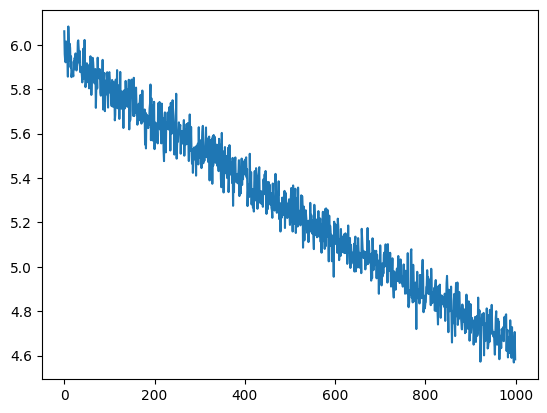

In [27]:
plt.plot(losses_1000)

In [30]:
for i in range(5):
    print("-----------------------------------")
    print("EmilioBot 2.0: ", decode(model_1000.generate(idx, 20)[0].tolist()))
print("-----------------------------------")

-----------------------------------
EmilioBot 2.0:  
🐱👊5K💯🥺中8X国Jè@🐱Gz☕Ч进💃
-----------------------------------
EmilioBot 2.0:  
‘😫:Eiñ十.'😕🤔y6yã🤡🤞🥺ñ二
-----------------------------------
EmilioBot 2.0:  
三a大{}^三{💪二Bã三ьé’🤮(♂时
-----------------------------------
EmilioBot 2.0:  
’二лA🐱л喜B🌳🤝еа中è🥴U😐SÁ 
-----------------------------------
EmilioBot 2.0:  
d中进‼{🧐进S‍v🥹国👎о国老♂一sI
-----------------------------------


In [31]:
model_10000 = BigramLanguageModel(vocab_size)
optimizer = torch.optim.AdamW(model_10000.parameters(), lr=0.001)
losses_10000 = []
steps = 10000

for i in range(steps):
    xb, yb = get_batch("train", 32, 8, train_data, test_data)
    logits, loss = model_10000(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses_10000.append(loss.item())

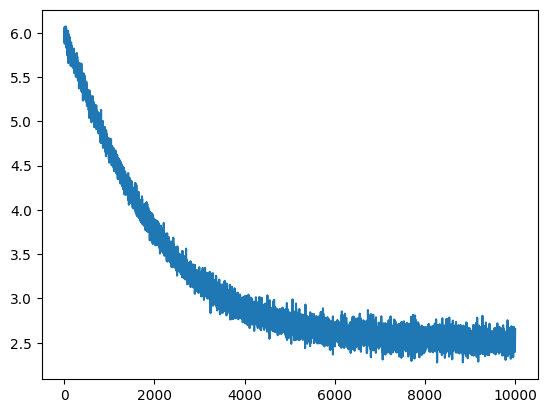

In [32]:
plt.plot(losses_10000)

In [119]:
for i in range(5):
    print("-----------------------------------")
    generation = decode(model_10000.generate(idx, 50)[0].tolist())
    if "\n" in generation:
        generation = generation[1:]
        if "\n" in generation:
            print("EmilioBot 2.0: ", generation[1:generation.index("\n")])
        else:
            print("EmilioBot 2.0: ", generation)
    else:
        print("EmilioBot 2.0: ", generation)
print("-----------------------------------")

-----------------------------------
EmilioBot 2.0:  Sthaches j我KK🤢💪的学🤨🍷😎)íGowo rermga akinbad imes NLi
-----------------------------------
EmilioBot 2.0:  I Thaware e f ing pes GV;😂ô法🤌’vonat’mikive t ke an
-----------------------------------
EmilioBot 2.0:  Me s Asplyo👎Xo t a llyeng drly,ytitintorowhengap3u
-----------------------------------
EmilioBot 2.0:  us f t it’sh P中🤓1/33d oue f y mar
-----------------------------------
EmilioBot 2.0:   this a
-----------------------------------


In [127]:
for i in range(5):
    print("-----------------------------------")
    print("EmilioBot 2.0: ", decode(model_10000.generate(idx, 20)[0].tolist()))
print("-----------------------------------")

-----------------------------------
EmilioBot 2.0:  
tathe’t tbay n
Gobeo
-----------------------------------
EmilioBot 2.0:  
IOV😨*🤙工RSio 2$😔Sofun
-----------------------------------
EmilioBot 2.0:  
JAnt’sisugey BBulefu
-----------------------------------
EmilioBot 2.0:  
Linly owape grtr bli
-----------------------------------
EmilioBot 2.0:  
D
Thishet
OEn bangin
-----------------------------------


In [128]:
model_25000 = BigramLanguageModel(vocab_size)
optimizer = torch.optim.AdamW(model_25000.parameters(), lr=0.001)
losses_25000 = []
steps = 25000

for i in range(steps):
    xb, yb = get_batch("train", 32, 8, train_data, test_data)
    logits, loss = model_25000(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses_25000.append(loss.item())

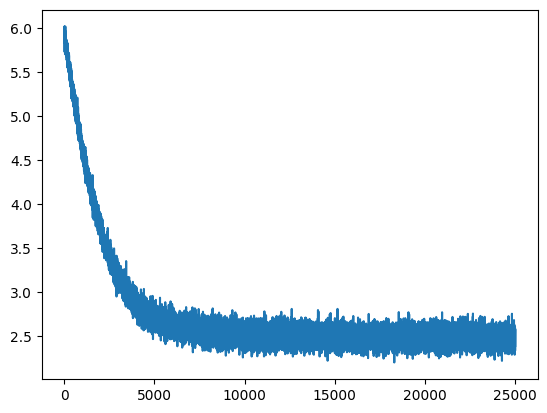

In [129]:
plt.plot(losses_25000)

In [130]:
for i in range(5):
    print("-----------------------------------")
    generation = decode(model_10000.generate(idx, 50)[0].tolist())
    if "\n" in generation:
        generation = generation[1:]
        if "\n" in generation:
            print("EmilioBot 2.0: ", generation[1:generation.index("\n")])
        else:
            print("EmilioBot 2.0: ", generation)
    else:
        print("EmilioBot 2.0: ", generation)
print("-----------------------------------")

-----------------------------------
EmilioBot 2.0:  ’dimth ce atbhee upr d I iken’m
-----------------------------------
EmilioBot 2.0:  INo thedk y acouetiketrorcrthauf alousthe itond RS
-----------------------------------
EmilioBot 2.0:  G2jeshisaheereve chire mif br️0000000000Z85😐三🤢😭=ç🧉
-----------------------------------
EmilioBot 2.0:  
-----------------------------------
EmilioBot 2.0:   ranguy h
-----------------------------------


In [133]:
for i in range(5):
    print("-----------------------------------")
    print("EmilioBot 2.0: ", decode(model_10000.generate(idx, 20)[0].tolist()))
print("-----------------------------------")

-----------------------------------
EmilioBot 2.0:  
Br wrerore10 nin t h
-----------------------------------
EmilioBot 2.0:  
I lyonthicit
Tin JAn
-----------------------------------
EmilioBot 2.0:  
Sl
Yelito Thoraverè'
-----------------------------------
EmilioBot 2.0:  
Yeet d
Itheinctor*️c
-----------------------------------
EmilioBot 2.0:  
Bu deme y rpllidne
W
-----------------------------------


---

---

Code from youtube tutorial

In [20]:
torch.__version__

'2.2.2+cu121'

In [21]:
torch.cuda.is_available()

True

In [23]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open(DATA_TXT, 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.231401 M parameters
step 0: train loss 5.7008, val loss 5.7023
step 100: train loss 2.7763, val loss 2.7804
step 200: train loss 2.5845, val loss 2.6091
step 300: train loss 2.5062, val loss 2.5394
step 400: train loss 2.4255, val loss 2.4727
step 500: train loss 2.3843, val loss 2.4117
step 600: train loss 2.3130, val loss 2.3504
step 700: train loss 2.2465, val loss 2.2826
step 800: train loss 2.1947, val loss 2.2511
step 900: train loss 2.1460, val loss 2.2031
step 1000: train loss 2.0848, val loss 2.1304
step 1100: train loss 2.0471, val loss 2.0952
step 1200: train loss 2.0296, val loss 2.0818
step 1300: train loss 1.9861, val loss 2.0426
step 1400: train loss 1.9640, val loss 2.0171
step 1500: train loss 1.9402, val loss 1.9876
step 1600: train loss 1.8996, val loss 1.9717
step 1700: train loss 1.8973, val loss 1.9668
step 1800: train loss 1.8700, val loss 1.9420
step 1900: train loss 1.8613, val loss 1.9288
step 2000: train loss 1.8212, val loss 1.9109
step 2100: train loss 1.

In [65]:
torch.save(m.state_dict(), "EmilioBot_Tensor")

In [43]:
print(decode(m.generate(context, 1000)[0].tolist()))


?
Citiona
But A2Eba ivalivions
What do watching tos tan virl in your fight that shitty something of Imostil Appeairacaliz ost picsopine some lifest hing
I think
No I fach I’m cart an the UAM
It’s advern for
It may dannne damn
Lato and “gonna”
And I mean in Hernna
Can thoy I’m guy
And the alwers can we live typort go decising women Axch
This shit?
I mivid to parts?
Did you?
So this nicdick bidess
You know find it obd I macroughts ly lajances
This is momica?
It may idk my hushive an fun Idk
JAJAJAJAJA
A what do Sday Turkish
Like
I hate like anjoy one rand frond by black I goatanrally and think of thind to dranding, Grect you hid a chille
And it’s think
On a vash
Good politude bc making luck id actick AMLb dad 2:00
My yourstedn’t sy hotty of it maigid it law me bring?
Why, Eura
To you ever liking mutary white whitith she or teamired aff
I don’t catgo
But it
May this that?
I told no other like
Imma ticken telens w find?
Bro In impeam agargies
de I can luct and after
Idk
You know
Colommaca

In [46]:

context = torch.zeros((1, 1), dtype=torch.long, device=device)
for i in range(5):
    print("-----------------------------------")
    generation = decode(m.generate(context, 100)[0].tolist())
    if "\n" in generation:
        generation = generation[1:]
        if "\n" in generation:
            print("EmilioBot 2.0: ", generation[1:generation.index("\n")])
        else:
            print("EmilioBot 2.0: ", generation)
    else:
        print("EmilioBot 2.0: ", generation)
print("-----------------------------------")

-----------------------------------
EmilioBot 2.0:  ike no putes
-----------------------------------
EmilioBot 2.0:   used rectiate 💀
-----------------------------------
EmilioBot 2.0:  rench I was seand to having rn tho
-----------------------------------
EmilioBot 2.0:   miss
-----------------------------------
EmilioBot 2.0:   was the an unner sight way 10 LYear orcen next he inclect to my girls
-----------------------------------


In [45]:
for i in range(3):
    print("------------------------------------------------------------")
    print("EmilioBot 2.0: ", decode(m.generate(context, 100)[0].tolist()))
print("------------------------------------------------------------")

------------------------------------------------------------
EmilioBot 2.0:  
Idk
JAJAJAJA
Wik
?
My centro mouth it
bro thank you gonna it
And hopen
I want to I mean it jost cont
------------------------------------------------------------
EmilioBot 2.0:  
O you purn Paris that hid is to do cam out of Jattizán take ffight
I sumuch that do to go and of the
------------------------------------------------------------
EmilioBot 2.0:  
?
Yo
?
?
Awercents people of teat
I actovels
I sstaves about Can
I kis Grecks
She is alragest and ho
------------------------------------------------------------


In [47]:
context

tensor([[0]], device='cuda:0')

In [58]:
input_context = torch.tensor([encode("Yo man what's up")], dtype=torch.long, device=device)
input_context

tensor([[57, 74,  1, 72, 60, 73,  1, 82, 67, 60, 79,  8, 78,  1, 80, 75]],
       device='cuda:0')

16

In [60]:
decode(m.generate(input_context, 100)[0].tolist())

"Yo man what's up the love prespeading\nNah\nYo some quiest\nC\nJAJAJA\nBo i think to mavidend\nI be hons that bigger\nI hav"

In [71]:
decode(m.generate(input_context, 100)[0].tolist())[len("Yo man what's up"):]

'\nI mean the Auplemb and onces\nI can way kout that the poplent in’t get like to stredé a do to I’m be'

In [95]:
message = input("Poyraz: ")
print("Poyraz: " + message)
input_context = torch.tensor([encode(message)], dtype=torch.long, device=device)
response = decode(m.generate(input_context, 20)[0].tolist())
print("EmilioBot 2.0: ", response[len(message):])

Poyraz: Yo whats up
EmilioBot 2.0:   anymes rn
Nah bc of


In [102]:
def parse_response(text, cutoff=50):
    res = text.replace("\n", "  ")
    return res[:cutoff + res[cutoff:].index(" ")]

model = BigramLanguageModel()
model.to(device)
model.load_state_dict(torch.load("EmilioBot_Tensor"))


print("\n\n-----------------------------------------------------\n\n")
cutoff = random.randint(0, 40)
message = "It's"
print("Poyraz: " + message + "\n")
input_context = torch.tensor([encode(message)], dtype=torch.long, device=device)
response = parse_response(decode(model.generate(input_context, cutoff+50)[0].tolist())[len(message):], cutoff)
print("EmilioBot 2.0: ", response, "\n")
print("\n\n-----------------------------------------------------\n\n")



-----------------------------------------------------


Poyraz: It's

EmilioBot 2.0:   acrigies basier  Like I scoon 



-----------------------------------------------------


